For a better vizualisation of this notebook please read it using the [notebook viewer](http://nbviewer.jupyter.org/github/cgallay/Ada/blob/master/Homework3/HOMEWORK%203.ipynb#?flush_cache=true)

In [1]:
%reload_ext autoreload
%autoreload 2
from folium import plugins
from pprint import pprint
from helpers import *
import pandas as pd
import branca
import folium
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import vincent
%matplotlib inline 

# Part 1

In order to get the data for the unemployment rate in Europe at a country level we went through the different datasets present in the statistics offices of the European commission website ([eurostat](http://ec.europa.eu/eurostat/data/database)).
We chose a dataset containing the mean of the unemployment rate during the month of July 2017, which was the last month updated with no missing values.

### Data Description : 
The Unemployment - LFS adjusted series (including also Harmonised long-term unemployment) is a collection of monthly, quarterly and annual series based on the quarterly results of the EU Labour Force Survey (EU-LFS).
The data set do not contain missing values, however, some countries as Switzerland for example are not included. It represents the unemployment rate considering both males and females. 

### Definitions : 
The definitions of employment and unemployment, as well as other survey characteristics follow the definitions and recommendations of the International Labour Organisation. The definition of unemployment is further precised in Commission Regulation (EC) No 1897/2000.
This domain comprises collections of monthly, quarterly and annual averages of unemployed persons and unemployment rates. The relevant definitions are as follows:

**Unemployed persons** are all persons 15 to 74 years of age (16 to 74 years in ES, IT and the UK) who were not employed during the reference week, had actively sought work during the past four weeks and were ready to begin working immediately or within two weeks.

**The unemployment rate** is the number of people unemployed as a percentage of the labour force. The labour force is the total number of people employed and unemployed.




In [2]:
#Load the data and rename the name for Germany and the needed columns
df_unemployement = pd.DataFrame(pd.read_csv('data/une_rt_m_1_Data.csv'))[['GEO', 'Value']].sort_values('Value')
df_unemployement['GEO'] = df_unemployement['GEO'].replace('Germany (until 1990 former territory of the FRG)', 'Germany')
df_unemployement = df_unemployement.rename(columns={'GEO':'Country'}).set_index('Country')

#Append to our dataset the missing value of unemployment rate for Switzerland
swiss_data = pd.read_csv('data/Taux_chomage_072017.csv')
swiss_data = pd.DataFrame({'Country':['Switzerland'], 'Value':[swiss_data.iloc[-1]['Taux de chômage']]}).set_index('Country')

df_unemployement = df_unemployement.append(swiss_data)

### Data Mapping : 
In order to map our data on the map, we chose to use a discrete color interval. The minimum rate (starting at 0) is represented by a light-yellow color and the maximum (according to the max value of our dataset) in dark red. Moreover, since the rate distribution is concentrated in the lower values we chose to plot the colors according to a logarithmic function (as shown on the label).

In [3]:
euro_topo = os.path.join('topojson', 'europe.topojson.json')

m = folium.Map([55.519962, 16.633597], tiles='mapboxbright', zoom_start=4)
plugins.ScrollZoomToggler().add_to(m) #Block scroll
#These plugin allow the user to expand the map on full screen
plugins.Fullscreen(
    position='bottomright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True).add_to(m)

#Here the method log is used to have a more significant colour distribution on the map. 
#We chose 6 discrete values to represent the different rates.
serie = df_unemployement['Value']
colorscale = branca.colormap.linear.YlOrRd.to_step(data=serie, n=6, method='log', round_method='float')
colorscale.caption = 'Unemployment Rate (%)'
colorscale.add_to(m)

#The countries that are not contained in the dataset are shaded by a grey colour
def style_function(feature):
    rate = serie.get(feature['properties']['NAME'], None)
    return {
        'fillOpacity': 0.7, #let to 1 otherwise the colorscale legend doesn't match
        'weight': 1,
        'color': 'black',
        'fillColor': '#grey' if rate is None else colorscale(rate)
    }

folium.TopoJson(open(euro_topo),
               'objects.europe',
               style_function=style_function).add_to(m)
m

As seen on the map, Switzerland has one of the lowest unemployment rate in Europe.

## Part 2

We first found a dataset that includes the unemployment rates in Switzerland at a recent date on https://www.amstat.ch.
Using this data, we built another Choropleth map, this time showing the unemployment rate at the level of swiss cantons.

### Definition : 
The Swiss Confederation defines the rates as the number of people looking for a job divided by the size of the active population (scaled by 100). 


In [4]:
#Load dictionnary for canton to abrevation
dict_trans = pd.read_excel("./data/Canton_map.xlsx").set_index("Canton").to_dict()["Canton_abv"]

In [5]:
#Load the dataset containing the unemployment rate in swtizerland by canton
df_swiss = pd.read_excel('./data/Taux de chômage_base.xlsx')
df_swiss["Taux de chômage"] = df_swiss["Taux de chômage"].astype(float)
create_swiss_map(df_swiss, "Taux de chômage")

In the map above we can clearly see a trend where the french part has a higher unemployement rate, where the geneva canton has the highest rate and the Grison one of the lowest.

Here we used a different categorization in order to differentiate the unemployed people and the unemployed job-seekers

In [6]:
df_swiss["Demandeurs d'emploi chômeurs"] = df_swiss["Chômeurs inscrits"] - df_swiss["Demandeurs d'emploi non chômeurs"] 
df_swiss["Taux de chômage sans employe"] = df_swiss["Demandeurs d'emploi chômeurs"] * df_swiss["Taux de chômage"] / df_swiss["Demandeurs d'emploi"]
create_swiss_map(df_swiss, "Taux de chômage sans employe")

### Interpretation : 

This differentiation allows us to show some distinctions that were not really present in the first map. For exemple, between the Valais and Bern. Overall the unemployement rates have decreased with this new perspective.

## Part 3

The aim of this part, is to make a distinction between, *swiss* and *foreign* workers.
We will thus show the difference in unemployment rates between the two categories in each canton on a Choropleth map.


In [7]:
#Read the chosen dataset containing the different unemployment rate in function of swiss people and foreigners
swiss_df = pd.read_excel("data/Taux de chômage Nationalité.xlsx")
index = ["Région linguistique", "Grande région id", "Nationalité"]
#Use again the dictionnary to map the cantons to their abreviations
swiss_df["Canton_abv"] = swiss_df["Canton"].replace(dict_trans)
swiss_df_nat = swiss_df.set_index("Nationalité")

In [8]:
#Define the max value in order to plot the variation of rates according to the maximum value of both swiss and foreigners,
#in order to ease the comparison between both maps.
scale = max(swiss_df_nat.loc["Suisses"]["Taux de chômage"].max(), \
            swiss_df_nat.loc["Etrangers"]["Taux de chômage"].max())
colorscale = branca.colormap.linear.YlOrRd.scale(0, scale)

m1 = folium.Map([46.8734, 8.2200], zoom_start=7)
m2 = folium.Map([46.8734, 8.2200], zoom_start=7)

#Allow the user to zoom on the map
plugins.ScrollZoomToggler().add_to(m1)
plugins.ScrollZoomToggler().add_to(m2)

m1 = add_swiss_map(m1, swiss_df_nat.loc["Suisses"], colorscale)
m2 = add_swiss_map(m2, swiss_df_nat.loc["Etrangers"], colorscale)

#We thought that is was more significant and easier for comparison to display both maps on the same line
f = branca.element.Figure()
div = f.add_subplot(1, 2, 1, margin=0.005)
m1.add_to(div)
div2 = f.add_subplot(1, 2, 2, margin=0.005)
colorscale.add_to(m2)
m2.add_to(div2)

f.save(os.path.join('results', 'Features.html'))
f

On the left we see the map of Switzerland with the unemployement rate for Swiss people, while the map on the right show the unemployement rate for foreign people

### Interpretation :
It seems that the differences are more visible on the second map. This can be due to several factors such as the language, the proportion of strangers, the accessibility to certain type of job and the difficulty of integration.

## Part 3 Bis
Now let's refine the analysis by adding the differences between age groups. 
For this part, we decided to display an interactive map which show each canton’s bar plot by the mean of a marker.
Bellow you can also see the whole bar plot which contains all canton. We chose to use again the month of July 2017, in order to keep some consistency among the project.


In [9]:
df_age = pd.read_excel('data/Taux_de_chomage_age.xlsx')
df_age["Canton"] = df_age["Canton"].replace(dict_trans)
df_age = df_age.set_index("Canton")
df_age["Taux de chômage"] = df_age["Taux de chômage"].astype(float)

In [10]:
m = folium.Map([46.8734, 8.2200], zoom_start=8)
plugins.ScrollZoomToggler().add_to(m) #Block scroll
add_swiss_topo(m)
#In this function for each canton we add a pop up marker which display a barplot with the help of the imported module "Vincent
for canton in dic_can_to_pos:
    popup = folium.Popup()
    bar_point = {
        'x': df_age.loc[canton]["Age"].values,
        'y': df_age.loc[canton]["Taux de chômage"].values
    }
    bar_chart = vincent.Bar(bar_point,
                               iter_idx='x',
                                width=200,
                                height=200)
    bar_chart.axis_titles("Age category of "+ canton, "percentage of unemployement")
    folium.Vega(bar_chart, height=250, width=250).add_to(popup)
    folium.Marker(dic_can_to_pos[canton], popup=popup).add_to(m)

m

In [11]:
#Load the dataset that contains the unemployment rate by Canton and by age Category for the month of July 2017
swiss_age_df = pd.read_excel("data/taux_de_chomage_age.xlsx")

#In order to add some meaning to the final bar plot we chose to order the cantons by their unemployment rate mean
swiss_age_df["Taux de chômage"] = swiss_age_df["Taux de chômage"].astype(float)
my_dict = swiss_age_df.groupby(["Canton"])["Taux de chômage"].mean().to_dict()
swiss_age_df["moyenne"] = swiss_age_df["Canton"].replace(my_dict)
swiss_age_df = swiss_age_df.sort_values(["moyenne","Age"])
swiss_age_df.head()

,Canton,Age,Taux de chômage,Chômeurs inscrits,Demandeurs d'emplois,moyenne
9,Uri,15-24 ans,0.5,16,28,0.666667
10,Uri,25-49 ans,0.7,70,132,0.666667
11,Uri,50 ans et plus,0.8,43,105,0.666667
15,Obwald,15-24 ans,0.5,16,30,0.766667
16,Obwald,25-49 ans,0.8,96,166,0.766667


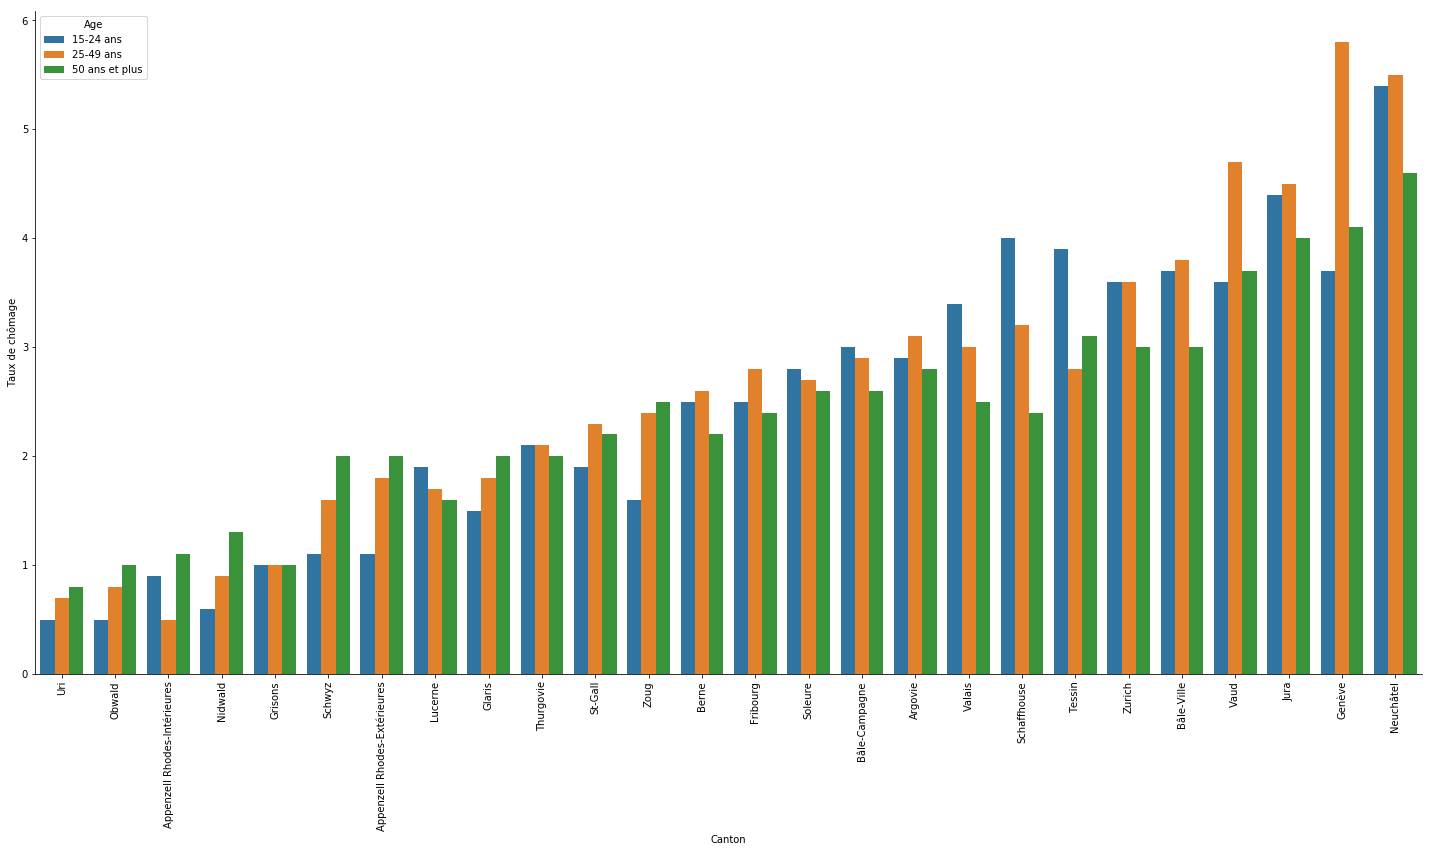

In [12]:
#The procedure to plot the final bar-plot
plt.figure()
swiss_age2_df = swiss_age_df.set_index(["Canton", "Age"])
t = swiss_age2_df.reset_index()
g = sns.factorplot(x="Canton", y="Taux de chômage", hue="Age", data=t, kind="bar", legend_out=False, size = 10, aspect = 2)
g.set_xticklabels(rotation=90)
plt.show()

### Interpretation : 
This way of representing the different rates is indeed efficient in order to compare the cantons between them and have a quick overview on the differences between the first and the last canton.

# Bonus

In [14]:
#Here we used the feature that group the several cantons according to their linguistic region
df_swiss["size_pop"] = (df_swiss["Demandeurs d\'emploi"] / df_swiss['Taux de chômage'])*100
group = df_swiss.groupby("Région linguistique").sum()[["Demandeurs d'emploi", "size_pop"]]
group["Taux"] = (group["Demandeurs d'emploi"] / group["size_pop"])*100
group

,Demandeurs d'emploi,size_pop,Taux
Région linguistique,,,
Suisse alémanique,120214,4.868104e+06,2.469421
Suisse romande et Tessin,73410,1.906515e+06,3.850480
Total,193624,6.454133e+06,3.000000


#### Interpretation : 
We can see roughly that the rate in general is higher in the french and italian parts of Switzerland